In [1]:
# Importing all necessary modules
import numpy as np
import torch
import random
import dgl
import networkx as nx
from utils import run_gnn_training, get_gnn
from maxcut_utils import goemans_williamson, graph_gen_regular, graph_randomize
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from scipy.interpolate import interp1d
import warnings

warnings.filterwarnings('ignore')

Using backend: pytorch


In [2]:
# Setting all seeds
def seed_set(seed_value=1):
    random.seed(seed_value)        # seed python RNG
    np.random.seed(seed_value)     # seed global NumPy RNG
    torch.manual_seed(seed_value)  # seed torch RNG

In [3]:
# Setting torch config
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32

In [4]:
TRY_COUNT = 10 # set number of runs for a specific graph configuration for better statistic representation
N = 40 # set graph size
K = [i for i in range(1,N) if i*N%2==0] # set range of graph degree
dim_embedding = 300 # set gnn input embeding
dropout = 0.0
hidden_dim = int(dim_embedding/2)  # et gnn hidden embeding
# NN learning hypers #
number_epochs = int(1000)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

In [5]:
def get_gw_mcut(g, n, k):
    (partition_gw, score_gw, up_score_gw), dt_gw = goemans_williamson(g)
    return {'score_gw': score_gw, 'up_score_gw': up_score_gw, 'dt_gw': dt_gw}

In [6]:
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': dropout,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

def get_gnn_mcut(g, n, k, opt_params, gnn_hypers):
    graph_dgl = dgl.from_networkx(nx_graph=g)
    graph_dgl = graph_dgl.to(TORCH_DEVICE)
    laplacian = - np.array(nx.laplacian_matrix(g).todense())
    q_torch = torch.tensor(laplacian, dtype=TORCH_DTYPE, device=TORCH_DEVICE)
    net, embed, optimizer = get_gnn(N, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)
    dt_gnn, epoch, final_bitstring, best_bitstring = run_gnn_training(
        q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
        gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])
    partition_gnn_best = best_bitstring.detach().cpu().numpy().astype('float32').reshape((best_bitstring.numel()))
    score_best = -1.0 * partition_gnn_best @ laplacian @ partition_gnn_best.T
    return {'score_gnn': score_best, 'dt_gnn': dt_gnn}

In [7]:
columns=['k', 'dt_gnn', 'dt_gw', 'score_gnn', 'score_gw', 'up_score_gw']
df_result = pd.DataFrame(columns=columns)

for seed_value in range(TRY_COUNT):
    seed_set(seed_value)
    for k in K:
        g = graph_gen_regular(N, k, seed_value)
        g = graph_randomize(g, seed_value)
        gw_res = get_gw_mcut(g, N, k)
        gnn_res = get_gnn_mcut(g, N, k, opt_params, gnn_hypers)
        final_res = {**gw_res, **gnn_res, 'k': k}
        df_result = df_result.append(final_res, ignore_index=True)
        

In [8]:
df_result

,k,dt_gnn,dt_gw,score_gnn,score_gw,up_score_gw
0,1.0,2.047086,0.742010,9.901037,9.901037,9.901037
1,2.0,2.917882,1.093876,19.394850,18.962869,20.117041
2,3.0,2.853206,1.160504,26.794658,26.293362,29.714891
3,4.0,2.905665,1.405737,35.103706,33.483966,36.499596
4,5.0,2.947321,1.187431,39.662030,38.691436,43.843360
...,...,...,...,...,...,...
385,35.0,3.105537,2.047972,190.202226,196.818014,205.933934
386,36.0,2.977619,2.169747,187.521010,199.659965,211.080879
387,37.0,2.863803,1.043704,194.107729,209.714582,214.832923
388,38.0,2.903016,1.628539,204.845606,203.856378,217.200613


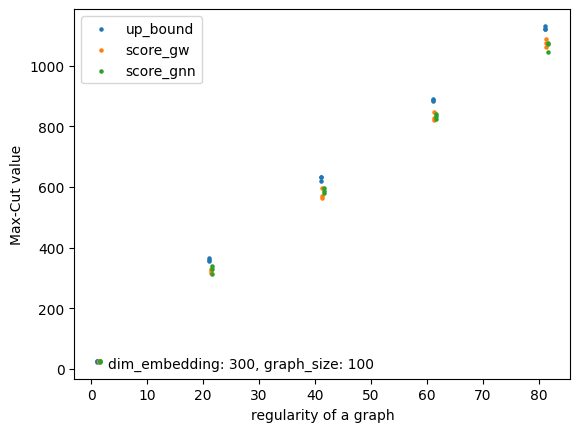

In [22]:
fig, ax = plt.subplots()

trans1 = Affine2D().translate(0.3, 0.0) + ax.transData
trans2 = Affine2D().translate(0.6, 0.0) + ax.transData

ax.scatter(df_result.k, df_result.up_score_gw, s=5, label ='up_bound')
ax.scatter(df_result.k, df_result.score_gw, s=5, label ='score_gw', transform=trans1)
ax.scatter(df_result.k, df_result.score_gnn, s=5, label ='score_gnn', transform=trans2)
ax.set_ylabel('Max-Cut value')
ax.set_xlabel('regularity of a graph')
ax.legend()
ax.text(3,3, f'dim_embedding: {dim_embedding}, graph_size: {N}')
plt.show()


Text(3, 3, 'dim_embedding: 300, graph_size: 40')

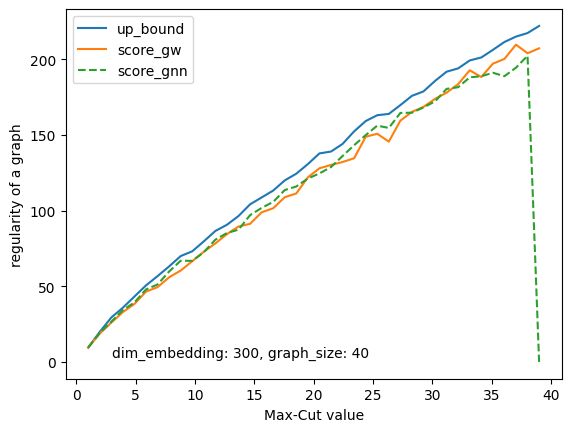

In [15]:
f_up = interp1d(df_result.k, df_result.up_score_gw)
f_gw = interp1d(df_result.k, df_result.score_gw)
f_gnn = interp1d(df_result.k, df_result.score_gnn)

x = np.linspace(df_result.k.min(), df_result.k.max(), num=40, endpoint=True)
plt.plot(x, f_up(x), '-', x, f_gw(x), '-', x, f_gnn(x), '--')
plt.ylabel('Max-Cut value')
plt.xlabel('regularity of a graph')
plt.legend(['up_bound', 'score_gw', 'score_gnn'], loc='best')
plt.text(3,3, f'dim_embedding: {dim_embedding}, graph_size: {N}')

Text(3, 5, 'dim_embedding: 300, graph_size: 40')

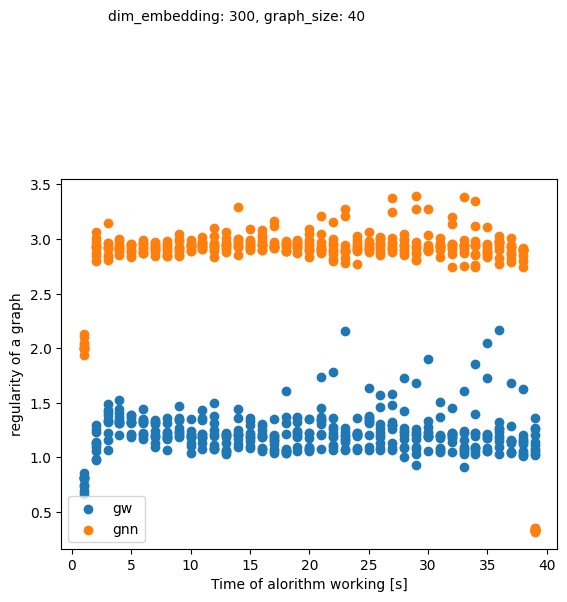

In [16]:
plt.scatter(df_result.k, df_result.dt_gw, label='gw')
plt.scatter(df_result.k, df_result.dt_gnn, label='gnn')
plt.xlabel('Time of alorithm working [s]')
plt.ylabel('regularity of a graph')
plt.legend()
plt.text(3, 5, f'dim_embedding: {dim_embedding}, graph_size: {N}')

In [17]:
columns=['k', 'dt_gnn', 'dt_gw', 'score_gnn', 'score_gw', 'up_score_gw']
df_result = pd.DataFrame(columns=columns)
TRY_COUNT = 3
N = 100 # set graph size
K = [i for i in range(1,N,20) if i*N%2==0] # set range of graph degree

for seed_value in range(TRY_COUNT):
    seed_set(seed_value)
    for k in K:
        g = graph_gen_regular(N, k, seed_value)
        g = graph_randomize(g, seed_value)
        gw_res = get_gw_mcut(g, N, k)
        gnn_res = get_gnn_mcut(g, N, k, opt_params, gnn_hypers)
        final_res = {**gw_res, **gnn_res, 'k': k}
        df_result = df_result.append(final_res, ignore_index=True)

In [18]:
df_result

,k,dt_gnn,dt_gw,score_gnn,score_gw,up_score_gw
0,1.0,2.924269,30.109992,23.311073,23.311073,23.311073
1,21.0,2.947397,51.593912,331.057918,316.423699,356.554801
2,41.0,2.863916,51.360304,598.628596,569.553076,634.693563
3,61.0,2.863844,46.741200,824.326494,846.346186,884.331361
4,81.0,2.784508,46.825932,1044.671650,1063.124842,1120.610169
5,1.0,2.948809,30.041506,25.840222,25.840222,25.840222
6,21.0,2.961062,47.596318,340.401173,330.592750,365.398156
7,41.0,2.936751,48.299283,585.912559,596.940479,634.134135
8,61.0,2.885811,43.293822,836.130915,828.931178,889.943377
9,81.0,2.901831,47.823198,1073.336179,1089.863011,1131.742991


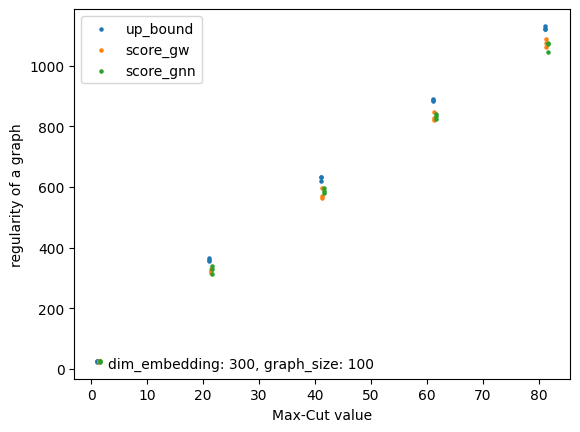

In [19]:
fig, ax = plt.subplots()

trans1 = Affine2D().translate(0.3, 0.0) + ax.transData
trans2 = Affine2D().translate(0.6, 0.0) + ax.transData

ax.scatter(df_result.k, df_result.up_score_gw, s=5, label ='up_bound')
ax.scatter(df_result.k, df_result.score_gw, s=5, label ='score_gw', transform=trans1)
ax.scatter(df_result.k, df_result.score_gnn, s=5, label ='score_gnn', transform=trans2)
ax.set_xlabel('Max-Cut value')
ax.set_ylabel('regularity of a graph')
ax.legend()
ax.text(3,3, f'dim_embedding: {dim_embedding}, graph_size: {N}')
plt.show()

Text(3, 3, 'dim_embedding: 300, graph_size: 100')

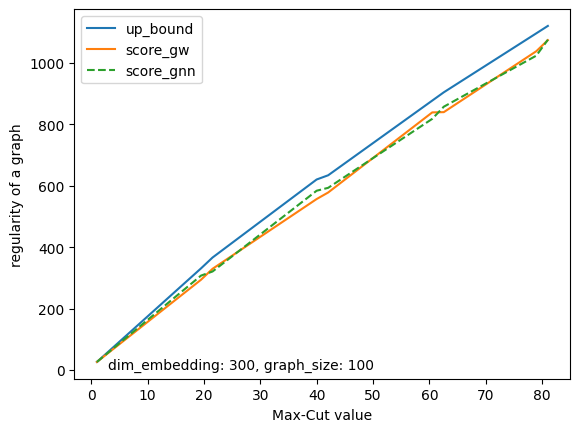

In [20]:
f_up = interp1d(df_result.k, df_result.up_score_gw)
f_gw = interp1d(df_result.k, df_result.score_gw)
f_gnn = interp1d(df_result.k, df_result.score_gnn)

x = np.linspace(df_result.k.min(), df_result.k.max(), num=40, endpoint=True)
plt.plot(x, f_up(x), '-', x, f_gw(x), '-', x, f_gnn(x), '--')
plt.ylabel('Max-Cut value')
plt.xlabel('regularity of a graph')
plt.legend(['up_bound', 'score_gw', 'score_gnn'], loc='best')
plt.text(3,3, f'dim_embedding: {dim_embedding}, graph_size: {N}')

Text(3, 5, 'dim_embedding: 300, graph_size: 100')

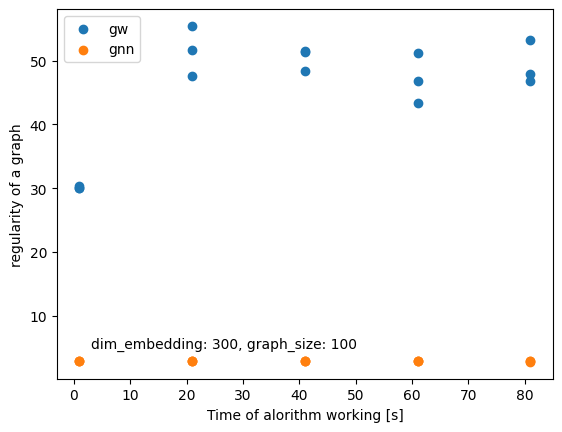

In [21]:
plt.scatter(df_result.k, df_result.dt_gw, label='gw')
plt.scatter(df_result.k, df_result.dt_gnn, label='gnn')
plt.xlabel('Time of alorithm working [s]')
plt.ylabel('regularity of a graph')
plt.legend()
plt.text(3, 5, f'dim_embedding: {dim_embedding}, graph_size: {N}')